**This notebook demonstrates decoherence and displays the Bloch vectors**
$$
   \newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}
   \newcommand{\ket}[1]{\left|{#1}\right\rangle}
   \newcommand{\bra}[1]{\left\langle{#1}\right|}
$$
- A circuit contains one or more registers
- A register contains one or more qubits

However we can construct an arbitrary number of circuits using the same registers: the circuits are simply run sequentially.

In [1]:
import os,sys
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import qiskit
from qiskit import IBMQ
from qiskit.tools.visualization import plot_bloch_vector, plot_bloch_multivector
from qiskit.providers.aer.noise.errors.standard_errors import thermal_relaxation_error
from qiskit.providers.aer.noise import NoiseModel
from qiskit.ignis.characterization.coherence import T1Fitter, T2StarFitter, T2Fitter
from qiskit.ignis.characterization.characterization_utils import pad_id_gates

# Import local tools
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import backend_tools
import tools

# Get a backend (can use the simulator as there is a Noise model)
IBMQ.load_accounts()
backend = backend_tools.get_device(use_sim=True, min_qubits=2)

**Energy relaxation experiment for measuring $T_1$**

In [21]:
# Build the circuit

# For each test, create 20 circuits with the number of identity gates ranging from 10 to 300,
# each with a wait time of 0.1 microseconds
num_of_gates = (np.linspace(10, 300, 20)).astype(int)
gate_time = 0.1

# Note that it is possible to measure several qubits in parallel
# - for this test we only use one qubit
qubits = [0]

# List of circuits with increasing wait time
xdata = gate_time * num_of_gates

qr = qiskit.QuantumRegister(max(qubits)+1)  # max(qubits)+1 can be used if the qubits were specified list [0,2]
cr = qiskit.ClassicalRegister(len(qubits))

# Build a list of circuits with increasing wait time
t1_circs = []
for circ_index, circ_length in enumerate(num_of_gates):
    circ = qiskit.QuantumCircuit(qr, cr)
    circ.name = 't1circuit_' + str(circ_index) + '_0'
    for _, qubit in enumerate(qubits):
        circ.x(qr[qubit])
        circ = pad_id_gates(circ, qr, qubit, circ_length)
        
    # Measure in X, Y and Z
    for qind, qubit in enumerate(qubits):
        # Measurement gates
        meas_x = qiskit.circuit.QuantumCircuit(qr, cr)
        meas_x.h(qr[qubit])
        meas_x.measure(qr[qubit], cr[qind])

        meas_y = qiskit.circuit.QuantumCircuit(qr, cr)
        meas_y.sdg(qr[qubit])
        meas_y.h(qr[qubit])
        meas_y.measure(qr[qubit], cr[qind])

        meas_z = qiskit.circuit.QuantumCircuit(qr, cr)
        meas_z.measure(qr[qubit], cr[qind])
    
    t1_circs.append(circ + meas_x)
    t1_circs.append(circ + meas_y)
    t1_circs.append(circ + meas_z)

*Display some of the circuits*

Circuit 1 - X measurement


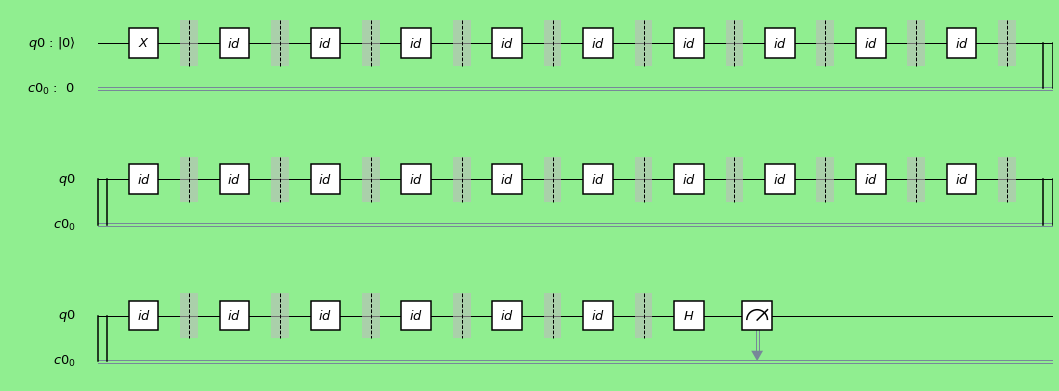

Circuit 1 - Y measurement


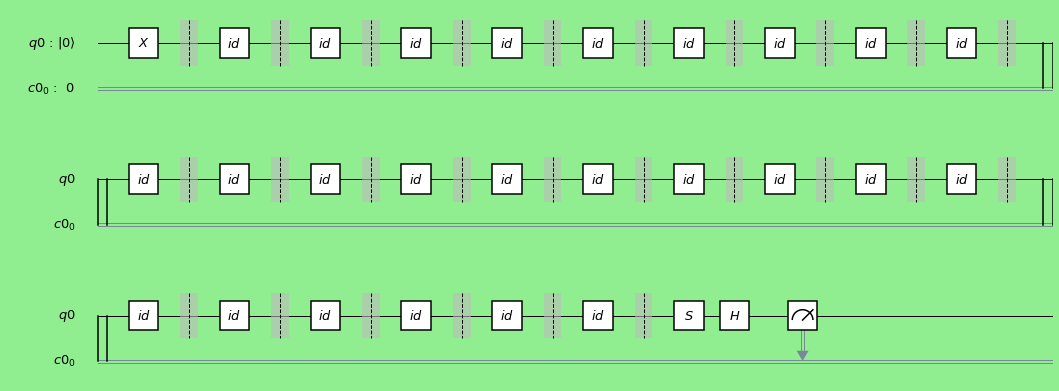

Circuit 1 - Z measurement


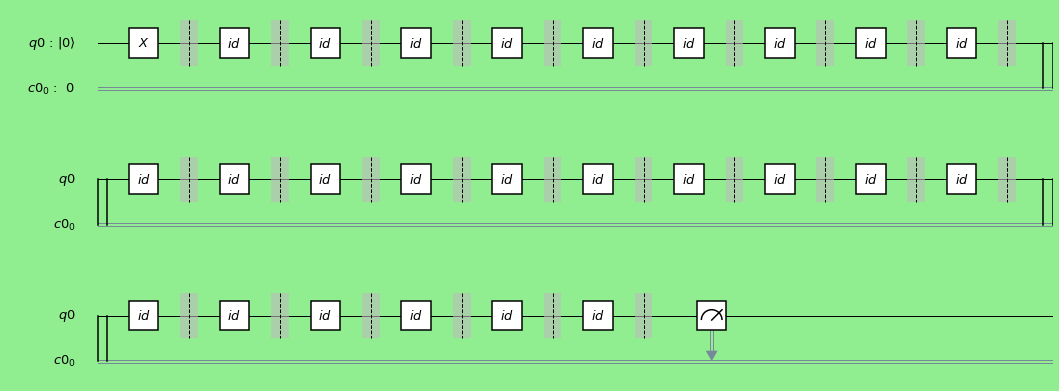

In [22]:
# Draw one of the circuits
style = {'backgroundcolor': 'lightgreen'}
circuit_no = 1
print("Circuit {:d} - X measurement".format(circuit_no))
tools.show_figure(t1_circs[circuit_no*3].draw(output='mpl', plot_barriers=True, reverse_bits=True, style=style, scale=0.7))

print("Circuit {:d} - Y measurement".format(circuit_no))
tools.show_figure(t1_circs[circuit_no*3+1].draw(output='mpl', plot_barriers=True, reverse_bits=True, style=style, scale=0.7))

print("Circuit {:d} - Z measurement".format(circuit_no))
tools.show_figure(t1_circs[circuit_no*3+2].draw(output='mpl', plot_barriers=True, reverse_bits=True, style=style, scale=0.7))

*Run the simulation*

In [5]:
shots = 1024

# Set the parameters for the noise model 
T1 = 15.0      # The T_1 relaxation time constant
T2 = 2.0 * T1  # The T_2 relaxation time constant
# -apply the noise model to the "id" gate, and qubit '0'
t1_noise_model = NoiseModel()
t1_noise_model.add_quantum_error(
    thermal_relaxation_error(T1, T2, gate_time), 'id', [0])

# Run the simulator
t1_backend_result = qiskit.execute(t1_circs, backend, shots=shots,
                                   noise_model=t1_noise_model, optimization_level=0).result()

*Display the results*

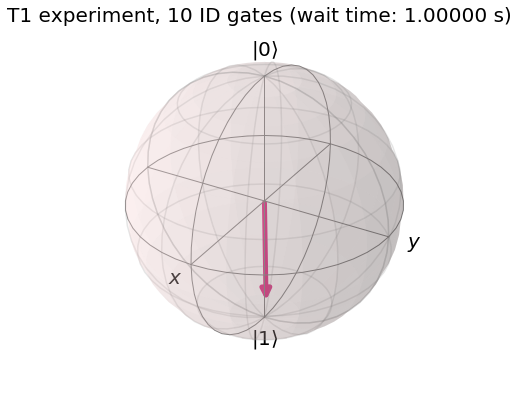

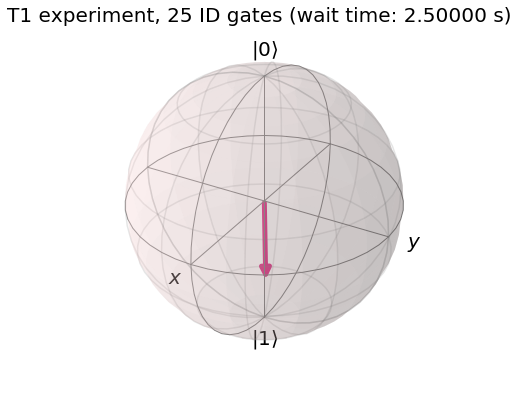

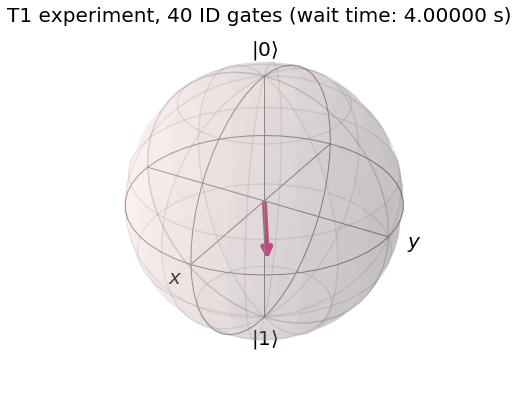

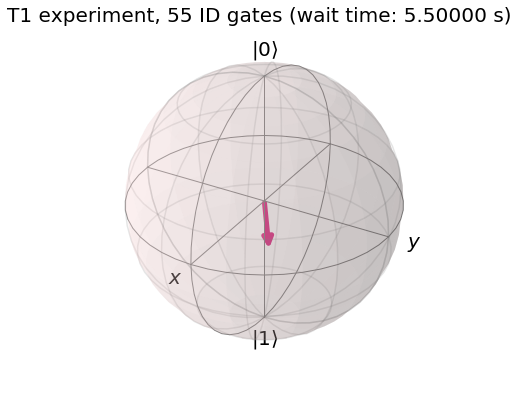

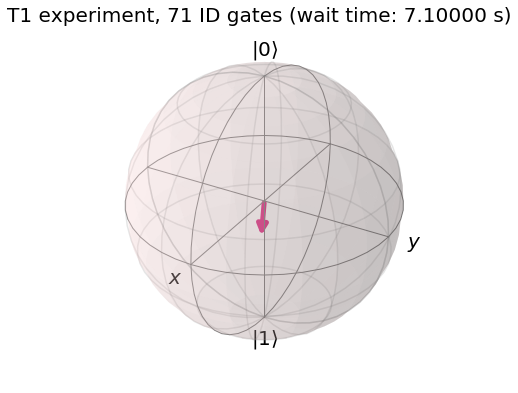

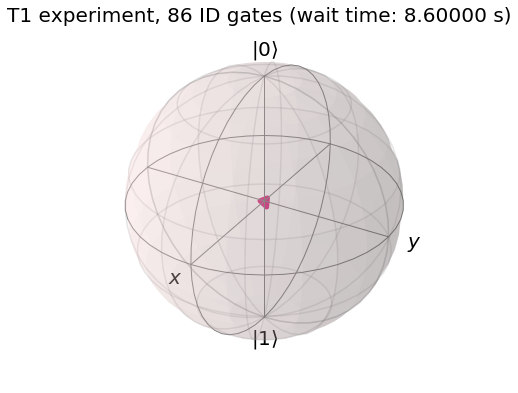

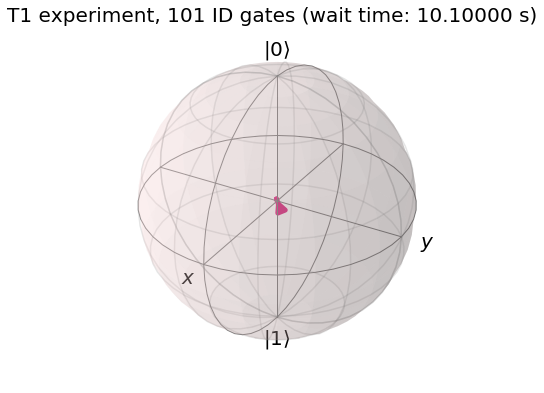

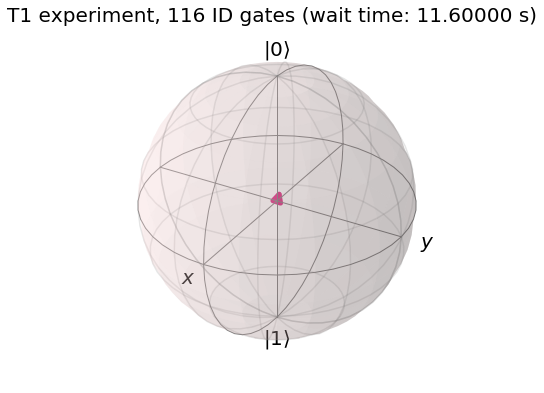

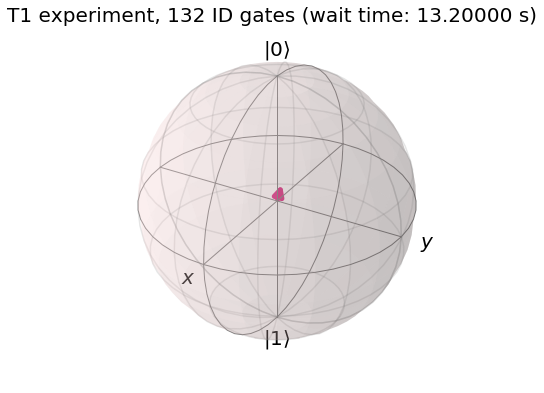

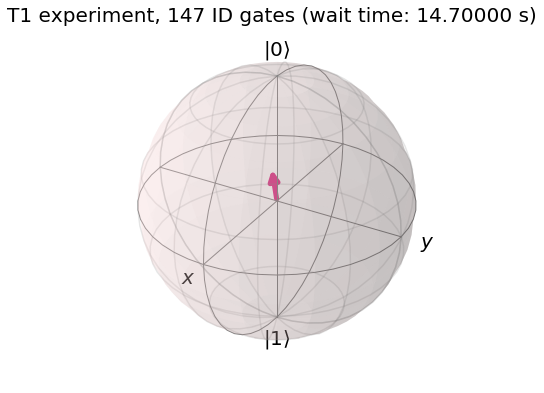

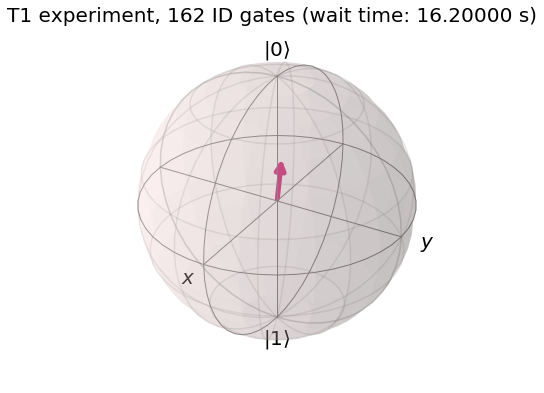

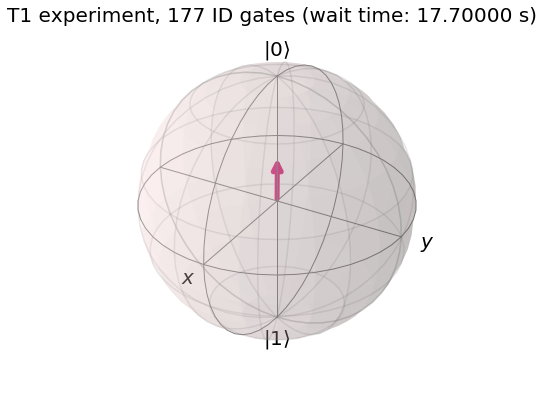

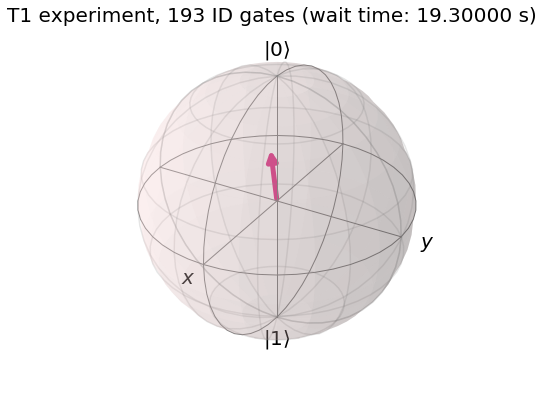

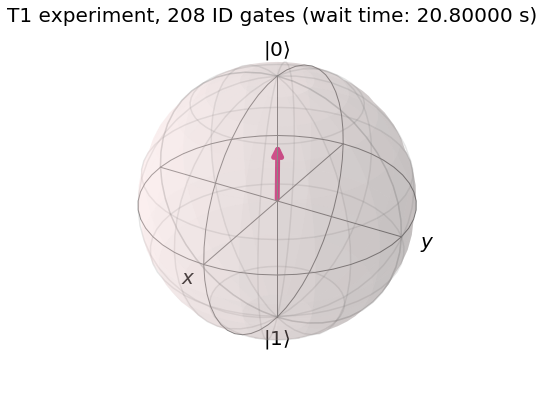

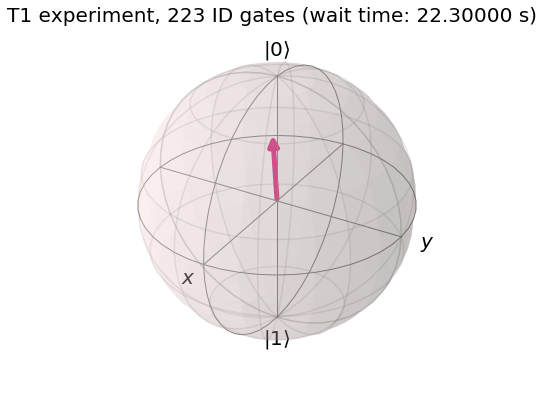

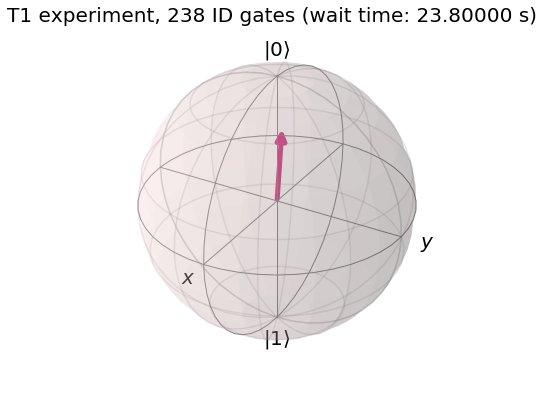

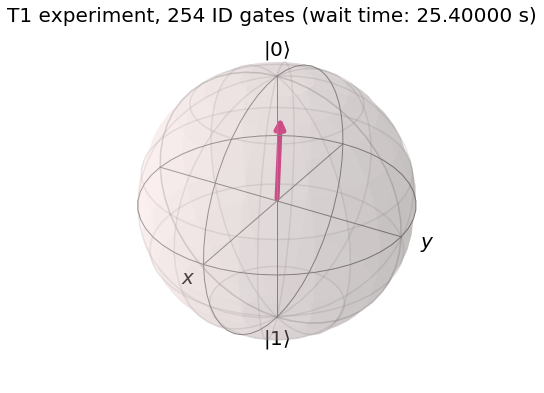

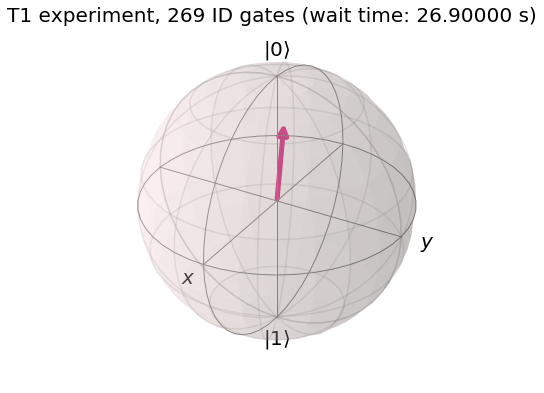

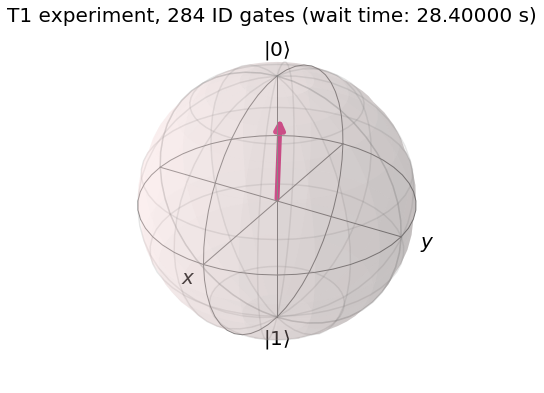

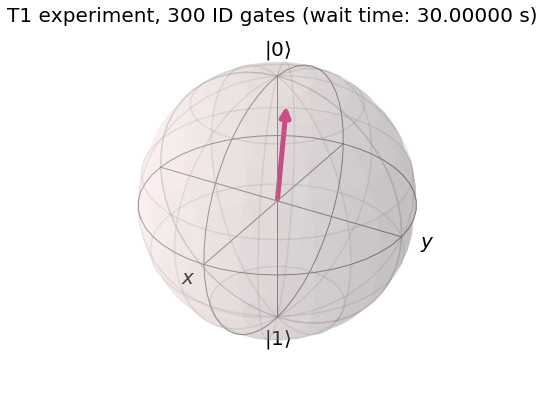

In [6]:
bloch_vector = ['x', 'y', 'z']
for circ_index, circ_length in enumerate(num_of_gates):
    no_gates = circ_length
    wait_time = gate_time * no_gates
    bloch = [0, 0, 0]
    for bloch_index in range(len(bloch_vector)):
        data = t1_backend_result.get_counts(t1_circs[3*circ_index+bloch_index])
        try:
            p0 = data['0']/shots
        except KeyError:
            p0 = 0
        try:
            p1 = data['1']/shots
        except KeyError:
            p1 = 0
        bloch[bloch_index] = p0-p1
    tools.show_figure(plot_bloch_vector(bloch, title='T1 experiment, {:d} ID gates (wait time: {:.5f} s)'.format(no_gates, wait_time)))

**Ramsey experiment for measuring $T_2^*$**

In [16]:
# Build the circuit

# For each test, create 25 circuits with the number of identity gates ranging from 1 to 300,
# each with a wait time of 0.1 microseconds
num_of_gates = (np.linspace(1, 300, 25)).astype(int)
gate_time = 0.1

# List of circuits with increasing wait time
xdata = gate_time * num_of_gates

# Note that it is possible to measure several qubits in parallel
# - however we must be careful to set the circuits up in such a way that
#   the qubits are in separate registers so they don't become entangled
#   (we wish to run two separate experiments, each with a single qubit)
registers = [0, 1]

# Create two circuits, each containing one qubit
# - the two qubits cannot be in the same register as they will become entangled
qr = len(registers) * [None]
cr = len(registers) * [None]
for index in range(len(registers)):
    qr_name = 'q' + str(index) # Appears as though the circuit drawing code can only handle names
    cr_name = 'c' + str(index) # of the form [a-z][0-9] i.e. a single letter followed by a digit
    qr[index] = qiskit.QuantumRegister(1, qr_name)
    cr[index] = qiskit.ClassicalRegister(1, cr_name)

# number of oscillations to induce using the phase gate
nosc = 5  
# the induced oscillation frequency (divide the total time by the desired number of oscillations over that time)
osc_freq = nosc/xdata[-1]

# Build a list of circuits with increasing wait time
# - each circuit consists of a Hadamard gate, followed by a sequence of identity gates, 
# a phase gate (with a linear phase), and an additional Hadamard gate.
t2star_circs = []
phase_angle = []
qubit = 0 # Each register only has a single qubit
for reg_index in range(len(registers)):
    for circ_index, circ_length in enumerate(num_of_gates):
        circ = qiskit.QuantumCircuit(qr[reg_index], cr[reg_index])
        circ.name = 't2starcircuit_register_' + str(reg_index) + '_circuit_' + str(circ_index)
    
        # Create the superposition |+>
        circ.h(qr[reg_index][qubit])
        # Wait
        circ = pad_id_gates(circ, qr[reg_index], qubit, circ_length)
        # Freq(cycles/sec) * time = cycles.
        # Cycles x 2.pi = number of radians
        angle = 2*np.pi*osc_freq*xdata[circ_index]
        circ.u1(angle, qr[reg_index][qubit])
        circ.h(qr[reg_index][qubit])
        circ.barrier(qr[reg_index][qubit])
        
        # Store the phase angles
        if reg_index == 0:
            phase_angle.append(angle)
    
        # Measure in X, Y and Z
        meas_x = qiskit.QuantumCircuit(qr[reg_index], cr[reg_index])
        meas_y = qiskit.QuantumCircuit(qr[reg_index], cr[reg_index])
        meas_z = qiskit.QuantumCircuit(qr[reg_index], cr[reg_index])
    
        meas_x.h(qr[reg_index][qubit])
        meas_x.measure(qr[reg_index], cr[reg_index])
        
        meas_y.sdg(qr[reg_index][qubit])
        meas_y.h(qr[reg_index][qubit])
        meas_y.measure(qr[reg_index], cr[reg_index])
        
        meas_z.measure(qr[reg_index], cr[reg_index])
    
        t2star_circs.append(circ + meas_x)
        t2star_circs.append(circ + meas_y)
        t2star_circs.append(circ + meas_z)
        
#print("Number of circuits to run: {} [should be {} gates * 3 axes * {} options (each in a different register)]".format(
#    len(t2star_circs), len(num_of_gates), len(registers)))

*Display some of the circuits*

Circuit 1 - X measurement


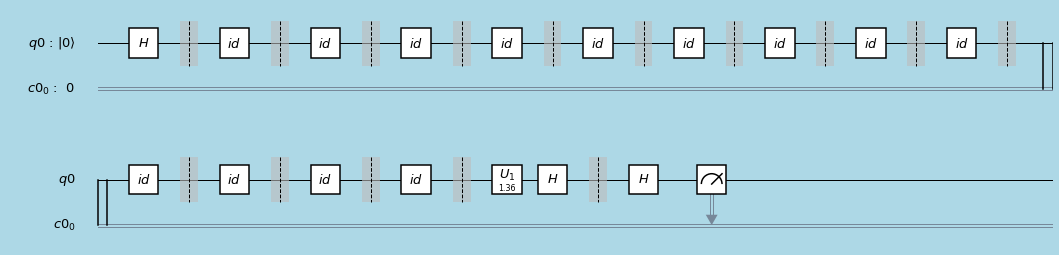

Circuit 1 - Y measurement


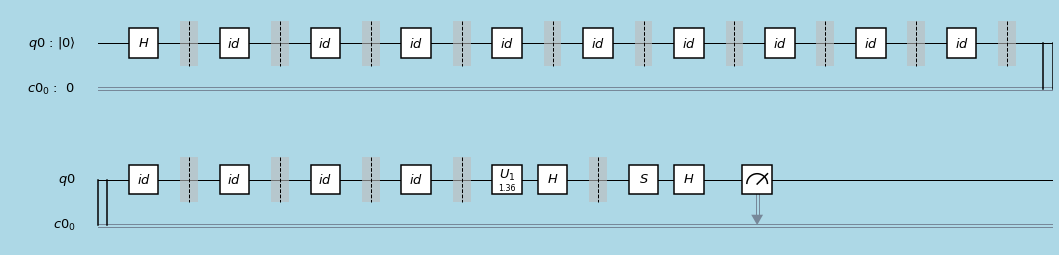

Circuit 1 - Z measurement


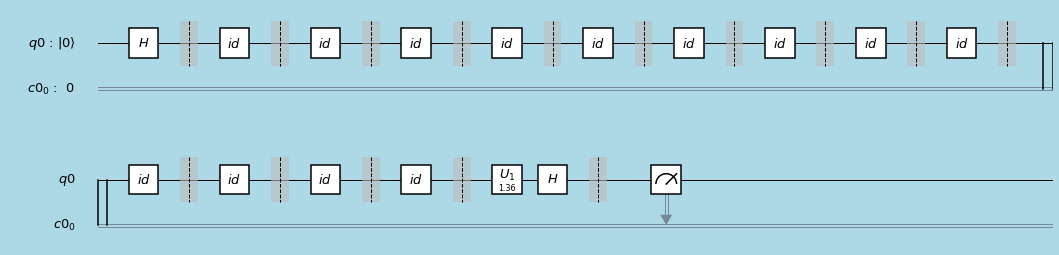

In [17]:
# Draw one of the circuits
style = {'backgroundcolor': 'lightblue'}
circuit_no = 1
print("Circuit {:d} - X measurement".format(circuit_no))
tools.show_figure(t2star_circs[circuit_no*3].draw(output='mpl', plot_barriers=True, reverse_bits=True, style=style, scale=0.7))

print("Circuit {:d} - Y measurement".format(circuit_no))
tools.show_figure(t2star_circs[circuit_no*3+1].draw(output='mpl', plot_barriers=True, reverse_bits=True, style=style, scale=0.7))

print("Circuit {:d} - Z measurement".format(circuit_no))
tools.show_figure(t2star_circs[circuit_no*3+2].draw(output='mpl', plot_barriers=True, reverse_bits=True, style=style, scale=0.7))

*Run the simulation*

In [20]:
shots = 1024

# Set the parameters for the noise model
T1 = np.inf
T2 = 5.0  # The T_2 relaxation time constant

# Define the noise model:
# - apply the noise model to the "id" gate, and qubit '0' in each register
t2_noise_model = NoiseModel()
# The 0.5 is the excited_state_population – the population of |1> state at equilibrium
t2_noise_model.add_quantum_error(thermal_relaxation_error(T1, T2, gate_time, 0.5), 'id', [0])

# Run the simulator
t2star_backend_result = 2 * [None]
t2star_backend_result[0] = qiskit.execute(t2star_circs, backend, shots=shots,
                                          noise_model=t2_noise_model, optimization_level=0).result()

# Repeat for the circuits in the other register
T2 = 30.0
t2_noise_model = NoiseModel()
t2_noise_model.add_quantum_error(thermal_relaxation_error(T1, T2, gate_time, 0.5), 'id', [0])
t2star_backend_result[1] = qiskit.execute(t2star_circs, backend, shots=shots,
                                          noise_model=t2_noise_model, optimization_level=0).result()

*Display the results*

No. gates: 1 Register 0 Bloch: -0.02734,0.07617,0.97461 Register 0 Bloch: -0.01953,0.11523,0.99414


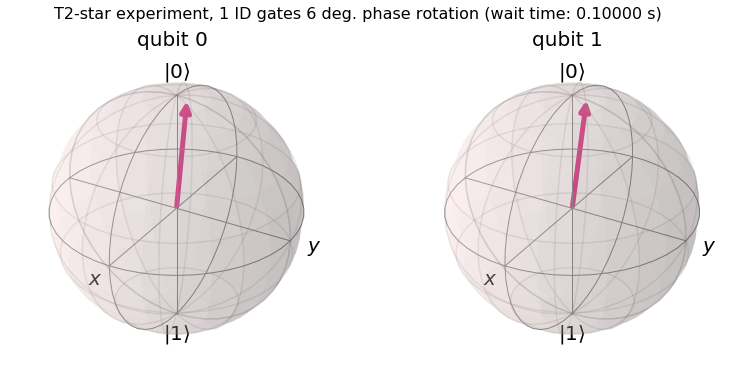

No. gates: 13 Register 0 Bloch: -0.02344,0.77539,0.12891 Register 0 Bloch: 0.01953,0.91406,0.22266


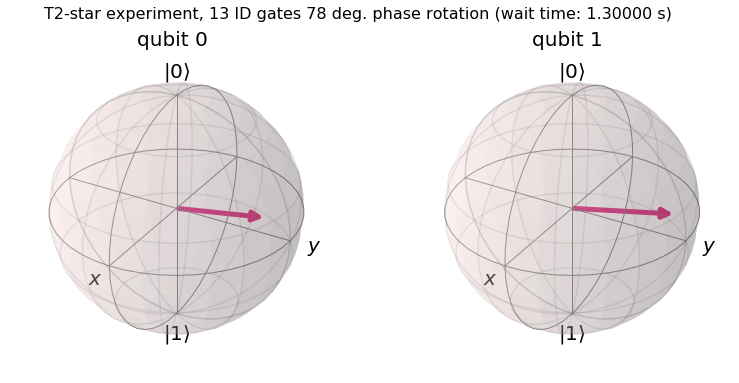

No. gates: 25 Register 0 Bloch: 0.00391,0.29102,-0.54102 Register 0 Bloch: 0.05859,0.43359,-0.76562


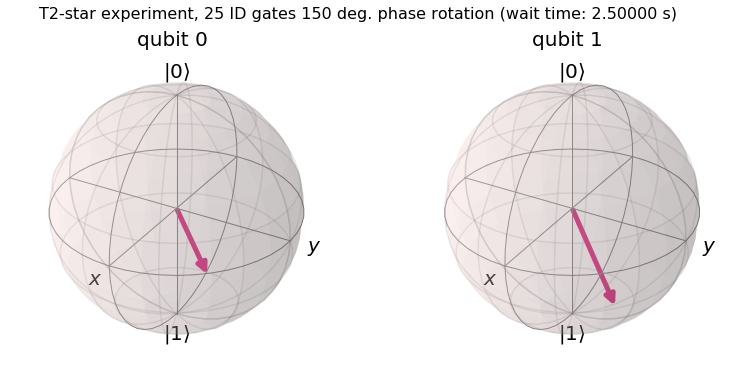

No. gates: 38 Register 0 Bloch: -0.03516,-0.32422,-0.35938 Register 0 Bloch: -0.03516,-0.62109,-0.61914


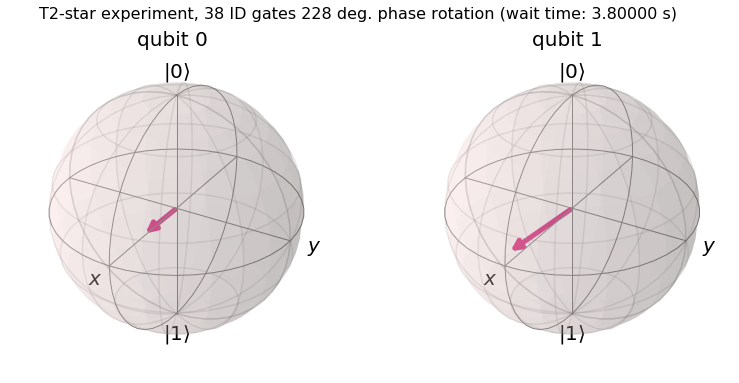

No. gates: 50 Register 0 Bloch: 0.02539,-0.30469,0.17188 Register 0 Bloch: -0.00781,-0.76562,0.45703


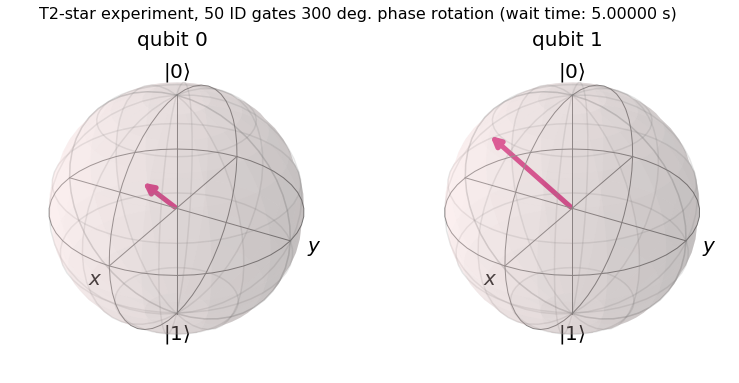

No. gates: 63 Register 0 Bloch: -0.04492,0.16992,0.28906 Register 0 Bloch: 0.01172,0.29883,0.75391


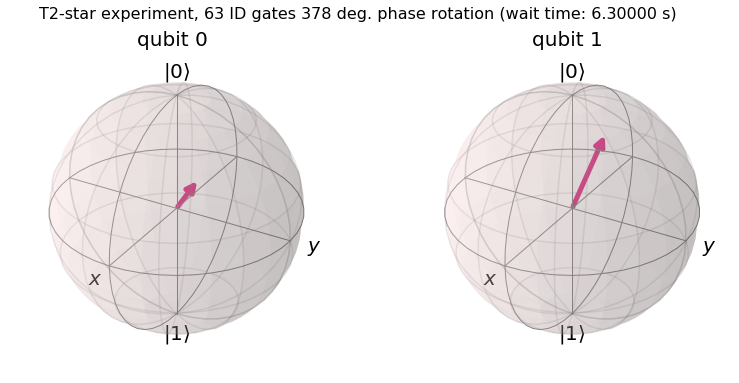

No. gates: 75 Register 0 Bloch: -0.03320,0.27344,-0.03320 Register 0 Bloch: -0.05664,0.75195,0.04102


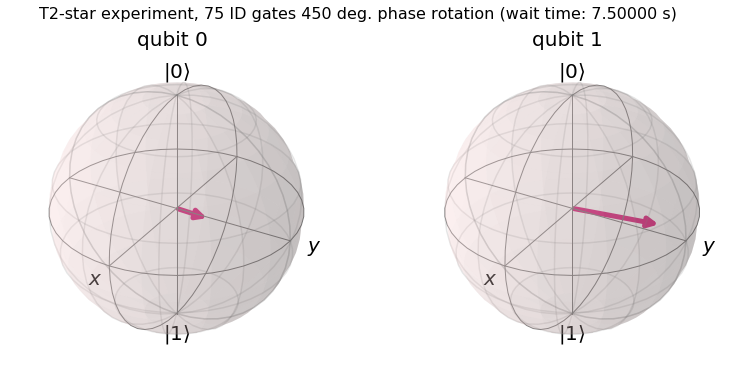

No. gates: 88 Register 0 Bloch: 0.00391,0.06641,-0.16602 Register 0 Bloch: -0.04102,0.17383,-0.76758


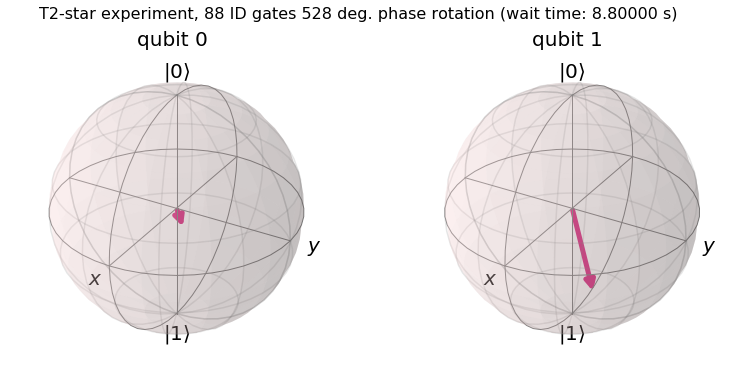

No. gates: 100 Register 0 Bloch: -0.00586,-0.14258,-0.11719 Register 0 Bloch: 0.01953,-0.66602,-0.34570


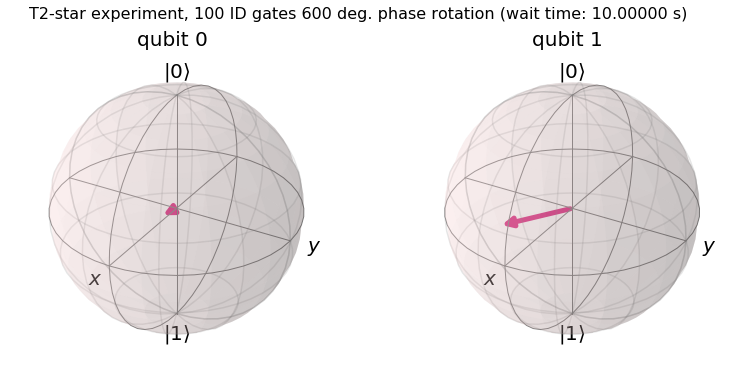

No. gates: 113 Register 0 Bloch: 0.01562,-0.05078,0.07031 Register 0 Bloch: -0.03516,-0.50000,0.50781


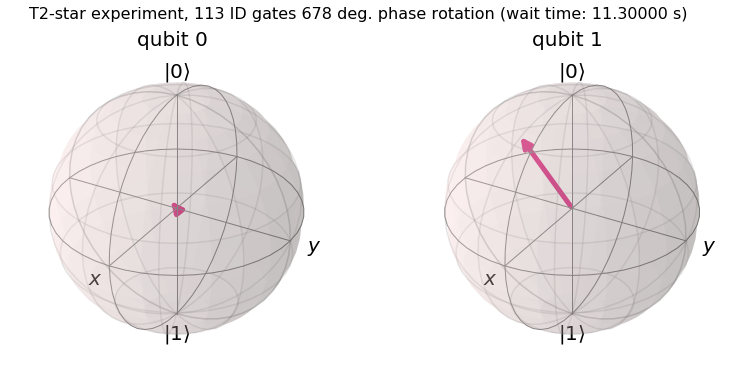

No. gates: 125 Register 0 Bloch: -0.01953,0.04688,0.06836 Register 0 Bloch: 0.03711,0.35938,0.58594


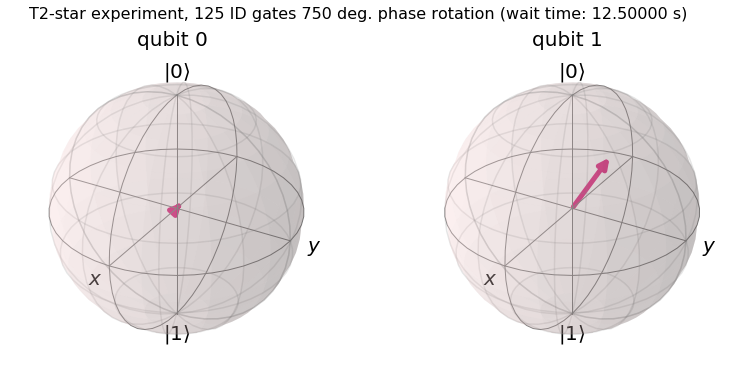

No. gates: 138 Register 0 Bloch: 0.07031,0.05469,-0.01562 Register 0 Bloch: 0.02930,0.59766,-0.21680


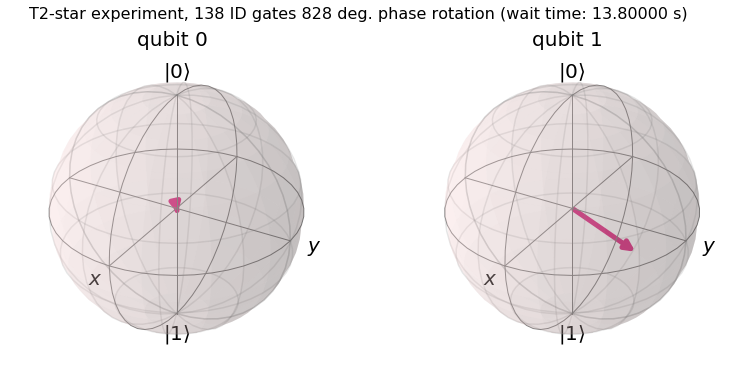

No. gates: 150 Register 0 Bloch: -0.00586,-0.02734,-0.08203 Register 0 Bloch: 0.01172,-0.00391,-0.58594


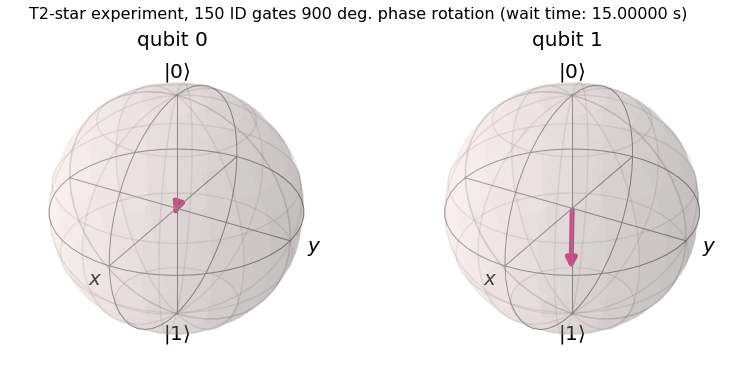

No. gates: 162 Register 0 Bloch: -0.02148,-0.03516,-0.05469 Register 0 Bloch: -0.01758,-0.53320,-0.22656


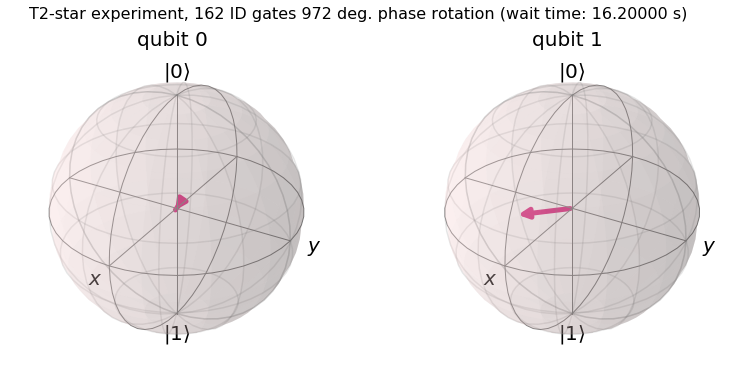

No. gates: 175 Register 0 Bloch: 0.02344,-0.01367,-0.01562 Register 0 Bloch: -0.01367,-0.29297,0.49609


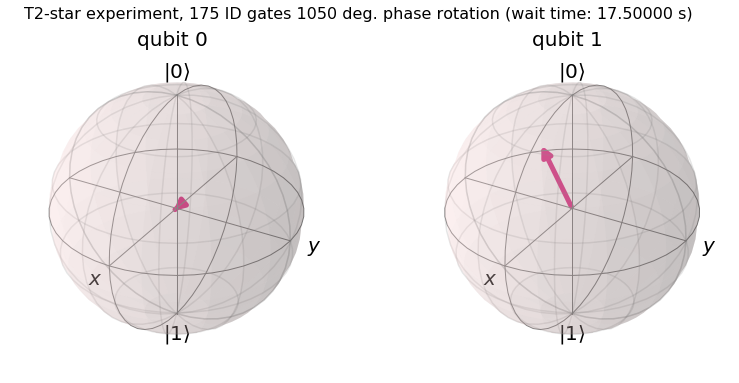

No. gates: 187 Register 0 Bloch: 0.06445,0.00977,0.03125 Register 0 Bloch: 0.03125,0.35547,0.41016


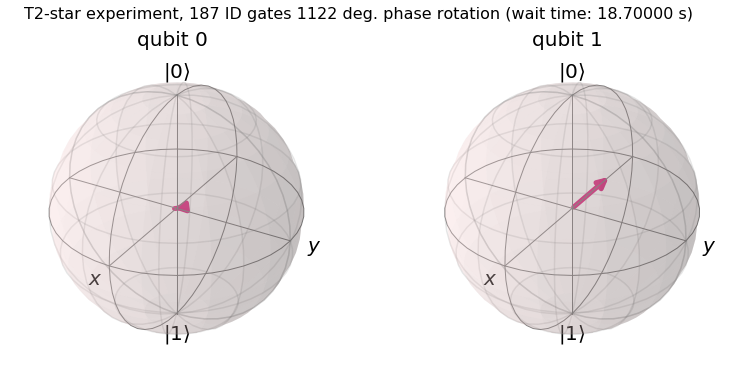

No. gates: 200 Register 0 Bloch: 0.01953,0.05859,0.03320 Register 0 Bloch: -0.02344,0.44531,-0.25391


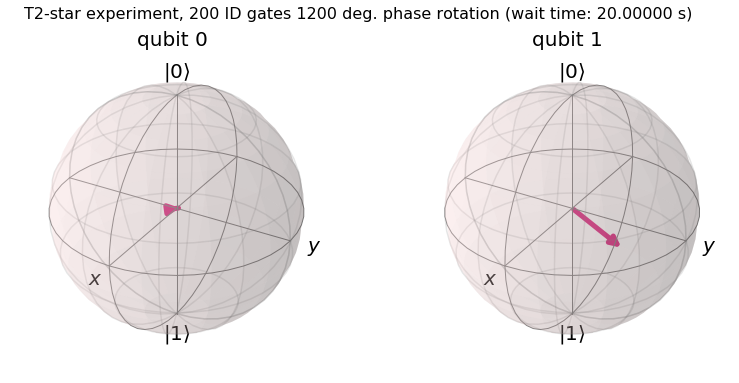

No. gates: 212 Register 0 Bloch: -0.01367,0.04883,0.01562 Register 0 Bloch: 0.00391,-0.09180,-0.44922


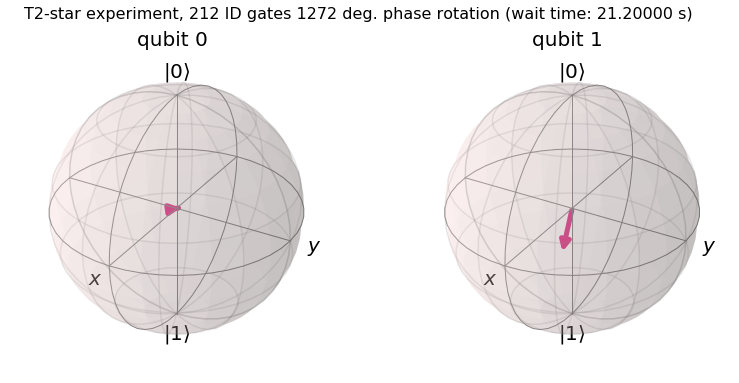

No. gates: 225 Register 0 Bloch: 0.00195,-0.01758,-0.03320 Register 0 Bloch: -0.03320,-0.47852,0.01758


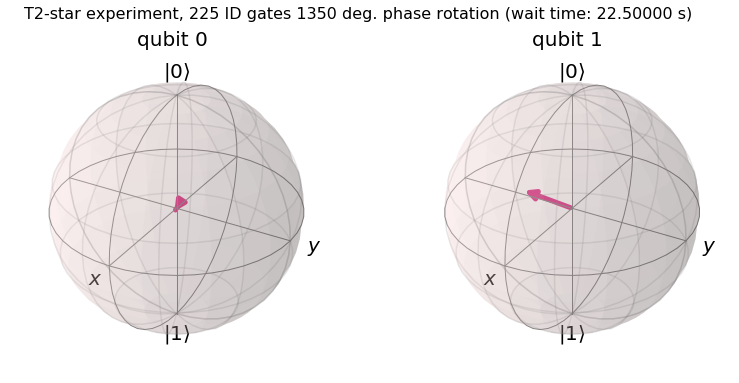

No. gates: 237 Register 0 Bloch: 0.04492,-0.06641,-0.02148 Register 0 Bloch: 0.06641,-0.14258,0.43750


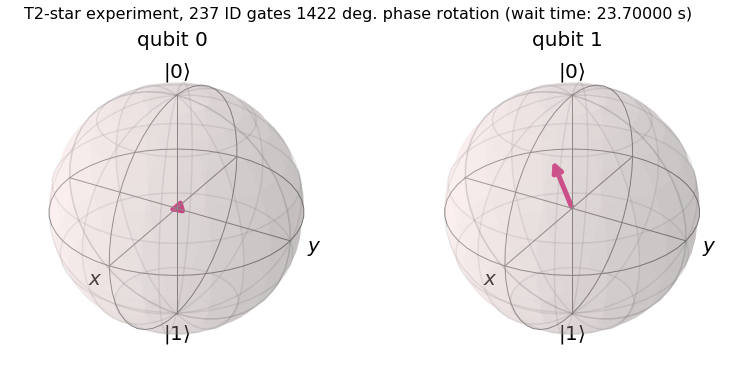

No. gates: 250 Register 0 Bloch: -0.02539,-0.01367,0.00781 Register 0 Bloch: 0.00586,0.35547,0.19727


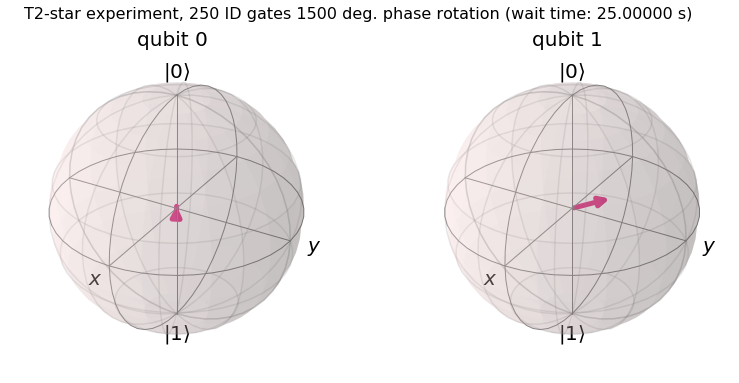

No. gates: 262 Register 0 Bloch: -0.03516,0.02148,-0.02344 Register 0 Bloch: 0.02344,0.29297,-0.29102


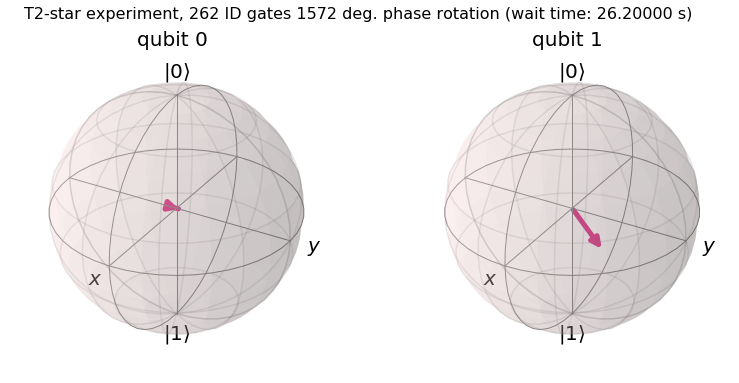

No. gates: 275 Register 0 Bloch: 0.01953,0.00000,0.01562 Register 0 Bloch: -0.00586,-0.20898,-0.35938


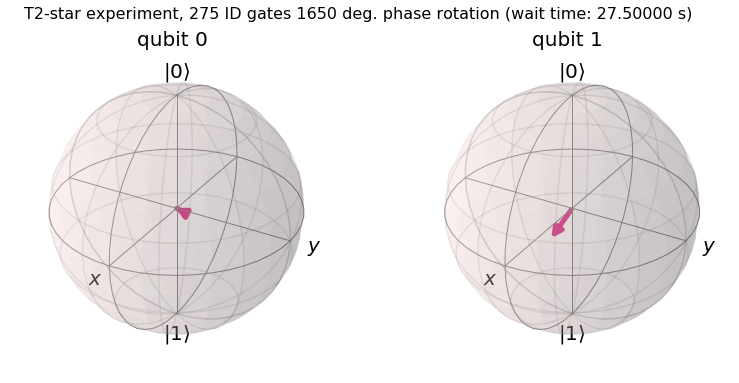

No. gates: 287 Register 0 Bloch: 0.00000,-0.05469,-0.03711 Register 0 Bloch: -0.01562,-0.33984,-0.01172


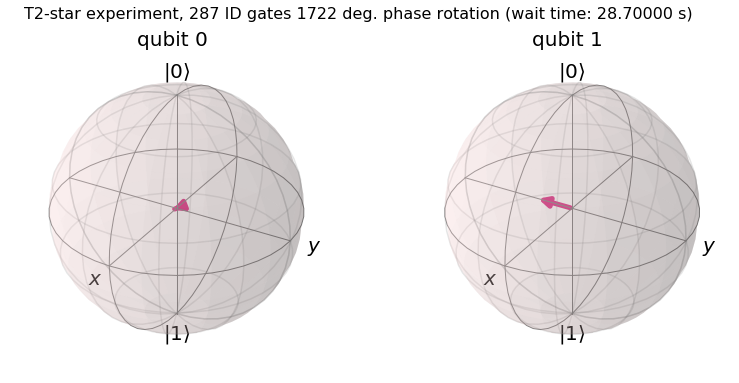

No. gates: 300 Register 0 Bloch: 0.03711,-0.05469,-0.01562 Register 0 Bloch: -0.04102,0.01172,0.32422


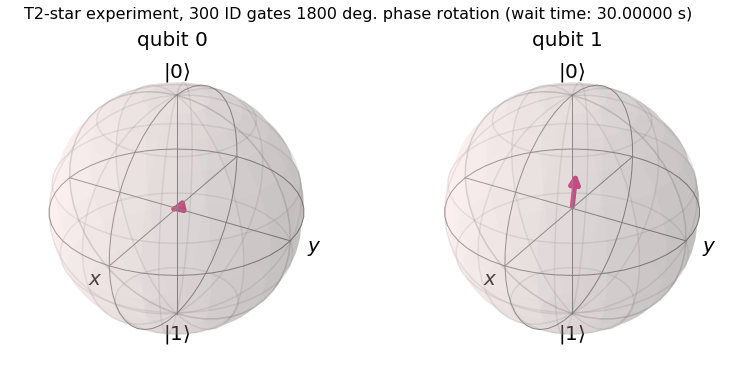

In [21]:
bloch_vector = ['x', 'y', 'z']

bv = len(registers)*[None]
for reg_index in range(len(registers)):
    bv[reg_index] = 3*[None]
    
no_circuits_per_register = len(num_of_gates) * 3
for circ_index, circ_length in enumerate(num_of_gates):
    no_gates = circ_length
    wait_time = gate_time * no_gates 

    for reg_index in range(len(registers)):
        for bloch_index in range(len(bloch_vector)):
            #print("Circuit {} Register {} Bloch index {} offset {} local index {}".format(
            #    circ_index, reg_index, bloch_index, reg_index*no_circuits_per_register, 3*circ_index+bloch_index))
            c = t2star_circs[reg_index*no_circuits_per_register + 3*circ_index+bloch_index]
            data = t2star_backend_result[reg_index].get_counts(c)
                
            try:
                p0 = data['0']/shots
            except KeyError:
                p0 = 0
            try:
                p1 = data['1']/shots
            except KeyError:
                p1 = 0
            bv[reg_index][bloch_index] = p0-p1
            
    print("No. gates: {} Register 0 Bloch: {:7.5f},{:7.5f},{:7.5f} Register 0 Bloch: {:7.5f},{:7.5f},{:7.5f}".format(
    circ_length, bv[0][0],bv[0][1],bv[0][2], bv[1][0],bv[1][1],bv[1][2]))
    
    # Plot the result for the experiment in each register
    angle = phase_angle[circ_index] * 180.0 / np.pi
    title='T2-star experiment, {:d} ID gates {:.0f} deg. phase rotation (wait time: {:.5f} s)'.format(no_gates, angle, wait_time)
    width = 13.0
    height = 6.0
    figsize=(width, height)
    fig = plt.figure(figsize=(width, height))
    num = len(registers)
    for i in range(num):
        ax = fig.add_subplot(1, num, i + 1, projection='3d')
        plot_bloch_vector(bv[i], "qubit " + str(i), ax=ax)
    fig.suptitle(title, fontsize=16)
    plt.show()

**Echo experiment for measuring $T_2$**

In [ ]:
# Build the circuit

*Display some of the circuits*

*Run the simulation*

*Display the results*

**CPMG circuit for measuring $T_2$**

In [ ]:
# Build the circuit

*Display some of the circuits*

*Run the simulation*

*Display the results*